# NNDSS data 
Build a line list from NNDSS data

In [8]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

def plot_results(df, int_vars:list, ax_arg=None, total=False,log=False, Reff=None,plotpath=False,legend=False,summary=False):
    if ax_arg is None:
        if Reff is None:
            fig, ax = plt.subplots(figsize=(12,9))
        else:
            #fig, (ax,ax2) = plt.subplots(figsize=(12,9),nrows=2,gridspec_kw={'height_ratios': [3, 1.5]}, sharex=True)
            fig = plt.figure(constrained_layout=True)
            gs = fig.add_gridspec(3, 1)
            ax = fig.add_subplot(gs[:2, 0])
            
            ax2 = fig.add_subplot(gs[2, 0],sharex=ax)
    else:

        ax2 = ax_arg[1]
        ax = ax_arg[0]
    if summary:
        #Using summary files
  
        for var in int_vars:
            df.columns = df.columns.astype('datetime64[ns]')
            ax.fill_between(df.columns, df.loc[(var,'lower')], df.loc[(var,'upper')], alpha=0.4,color='C0')
            ax.fill_between(df.columns, df.loc[(var,'bottom')], df.loc[(var,'top')], alpha=0.4,color='C0')

            if plotpath:
                print("Cannot plot path using summary files")
                raise KeyError
            else:
                ax.plot(df.columns, df.loc[(var,'median')], label=var)

            ax.set_xticks([df.columns.values[-28]],minor=True)
            ax.xaxis.grid(which='minor', linestyle='--',alpha=0.6, color='black')

    else:
        #using the raw simulation files
        if total:
            for n in range(df.loc['symp_obs'].shape[0]):
                df.loc[('total_inci_obs',n),:] = df.loc[(int_vars[0],n)] + df.loc[(int_vars[1],n)]
            int_vars=['total_inci_obs']
        for var in int_vars:
            df.columns = df.columns.astype('datetime64[ns]')
            ax.fill_between(df.columns, df.transpose()[var].quantile(0.05,axis=1), df.transpose()[var].quantile(0.95,axis=1), alpha=0.4,color='C0')
            ax.fill_between(df.columns, df.transpose()[var].quantile(0.25,axis=1), df.transpose()[var].quantile(0.75,axis=1), alpha=0.4,color='C0')

            if plotpath:
                ax.plot(df.columns, df.loc[(var,4)], label=var,alpha=0.6,color='C0')
                #ax.plot(df.columns, df.loc[(var,8)],alpha=0.6,color='C0')
                #ax.plot(df.columns, df.loc[(var,12)],alpha=0.8,color='C0')
            else:
                ax.plot(df.columns, df.transpose()[var].quantile(0.5,axis=1), label=var)

            ax.set_xticks([df.columns.values[-28]],minor=True)
            ax.xaxis.grid(which='minor', linestyle='--',alpha=0.6, color='black')
    
    if len(int_vars)>1:
        ax.legend()
    ax.set_ylim(bottom=0)
    #ax.set_ylabel("Cases")
    if log:
        ax.set_yscale("log")
    if legend:
        fig.legend()
    
    if Reff is not None:

        ax2.plot(df.columns, Reff.loc[df.columns,range(1000)].mean(axis=1))
        ax2.fill_between(df.columns, Reff.loc[df.columns, 'bottom'],Reff.loc[df.columns, 'top'],alpha=0.4 ,color='C0')
        ax2.fill_between(df.columns, Reff.loc[df.columns, 'lower'],Reff.loc[df.columns, 'upper'],alpha=0.4,color='C0' )
        ax2.set_yticks([1],minor=True,)
        ax2.set_yticks([0,2],minor=False)
        ax2.set_yticklabels([0,2],minor=False)
        ax2.yaxis.grid(which='minor',linestyle='--',color='black',linewidth=2)
        #ax2.set_ylabel("Reff")
        ax2.tick_params('x',rotation=45)
        plt.setp(ax.get_xticklabels(), visible=False)
        #ax2.set_xlabel("Date")
        
        ax2.set_xticks([df.columns.values[-28]],minor=True)
        ax2.xaxis.grid(which='minor', linestyle='--',alpha=0.6, color='black')

    else:
        #ax.set_xlabel("Date")
        ax.tick_params('x',rotation=45)
    if ax_arg is None:
        if Reff is None:
            return fig,ax
        else:
            return fig,ax,ax2
    else:
        return ax,ax2

def read_in_Reff(forecast_R=None,R_I=None,file_date = "2020-04-01"):
        """
        Read in Reff csv from Price et al 2020. Originals are in RDS, are converted to csv in R script
        """
        import pandas as pd
        import os
        
        dir_path = os.path.dirname(os.getcwd())
        
        datapath = os.path.join(dir_path,'data/')
        #df= pd.read_csv(datapath+'R_eff_2020_04_23.csv', parse_dates=['date'])
        #df = df.loc[df.date>= self.start_date]
        
        #df = df.set_index(['state','date'])
        
        
        if forecast_R is not None:
            df_forecast = pd.read_hdf(datapath+'soc_mob_R'+file_date+'.h5',
            key='Reff')
            
            if R_I is not None:
                mean = df_forecast.loc[df_forecast.type=='R_I','mean'].values[0]
                std = df_forecast.loc[df_forecast.type=='R_I','std'].values[0]
                R_I = np.random.gamma(mean**2/std**2, std**2/mean, size=100)

            #R_L here 
   

            df_forecast = df_forecast.loc[df_forecast.type==forecast_R]
            df_forecast.set_index(['state','date'],inplace=True)
            df = df_forecast
            #df = pd.concat([
            #            df.drop(['type','date_onset','confidence',
            #                 'mean_window','prob_control',
            #                'sd_window'],axis=1),
            #            df_forecast.drop(['type'],axis=1)
            #                ])
            #df = df.reset_index().drop_duplicates(['state','date'],keep='last')
            #df = df.set_index(['state','date'])
        
        
        return df
    
def read_in_cases(cases_file_date=None):
    """
    Read in NNDSS case file data
        
    """
    import pandas as pd
    from datetime import timedelta
    import glob

    if cases_file_date is None:
        import glob, os

        list_of_files = glob.glob("../data/"+'COVID-19 UoM*.xlsx') 
        path = max(list_of_files, key=os.path.getctime)
        print("Using file "+path)
    else:
        path = "../data/"+"COVID-19 UoM "+cases_file_date+"*.xlsx"

    for file in glob.glob(path):
        df = pd.read_excel(file,
                   parse_dates=['SPECIMEN_DATE','NOTIFICATION_DATE','NOTIFICATION_RECEIVE_DATE','TRUE_ONSET_DATE'],
                   dtype= {'PLACE_OF_ACQUISITION':str})
    if len(glob.glob(path))!=1:
        print("There are %i files with the same date" %len(glob.glob(path)))

        if len(glob.glob(path)) >1:
            print("Using an arbritary file")
    
    df.PLACE_OF_ACQUISITION.fillna('00038888',inplace=True) #Fill blanks with simply unknown

    df['date_inferred'] = df.TRUE_ONSET_DATE
    #missing_cases = df.groupby('STATE').TRUE_ONSET_DATE.agg(lambda x: sum(x.isna()))
    #print("Unknown Symptom onset dates")
    #display(missing_cases)
    df.loc[df.TRUE_ONSET_DATE.isna(),'date_inferred'] = df.loc[df.TRUE_ONSET_DATE.isna()].NOTIFICATION_DATE - timedelta(days=5)
    df.loc[df.date_inferred.isna(),'date_inferred'] = df.loc[df.date_inferred.isna()].NOTIFICATION_RECEIVE_DATE - timedelta(days=6)

    df['imported'] = df.PLACE_OF_ACQUISITION.apply(lambda x: 1 if x[-4:]=='8888' and x != '00038888' else 0)
    df['local'] = 1 - df.imported
    
    
    df_cases_state_time = df.groupby(['STATE','date_inferred'])[['imported','local']].sum()
    df_cases_state_time.reset_index(inplace=True)
    
    df_cases_state_time['cum_imported'] = df_cases_state_time.groupby('STATE').imported.transform(pd.Series.cumsum)
    df_cases_state_time['cum_local'] = df_cases_state_time.groupby('STATE').local.transform(pd.Series.cumsum)

    return df_cases_state_time

In [29]:
forecast_type = 'R_L' #default None
df_cases_state_time = read_in_cases(cases_file_date="15Jul")
Reff = read_in_Reff( forecast_R=forecast_type, file_date= "2020-07-15")


df_cases_state_time.loc[df_cases_state_time.STATE=='VIC'].tail(10)

,STATE,date_inferred,imported,local,cum_imported,cum_local
519,VIC,2020-07-05,1,237,985,2505
520,VIC,2020-07-06,0,212,985,2717
521,VIC,2020-07-07,0,312,985,3029
522,VIC,2020-07-08,0,204,985,3233
523,VIC,2020-07-09,0,81,985,3314
524,VIC,2020-07-10,0,78,985,3392
525,VIC,2020-07-11,0,40,985,3432
526,VIC,2020-07-12,0,13,985,3445
527,VIC,2020-07-13,0,14,985,3459
528,VIC,2020-07-14,0,4,985,3463


In [30]:
#check if any dates are incorrect
df_cases_state_time.loc[(df_cases_state_time.STATE=="VIC") &
                       (df_cases_state_time.date_inferred<='2020-01-01')]

,STATE,date_inferred,imported,local,cum_imported,cum_local
384,VIC,2002-07-03,0,1,0,1


forecast up to: 2020-08-12 00:00:00


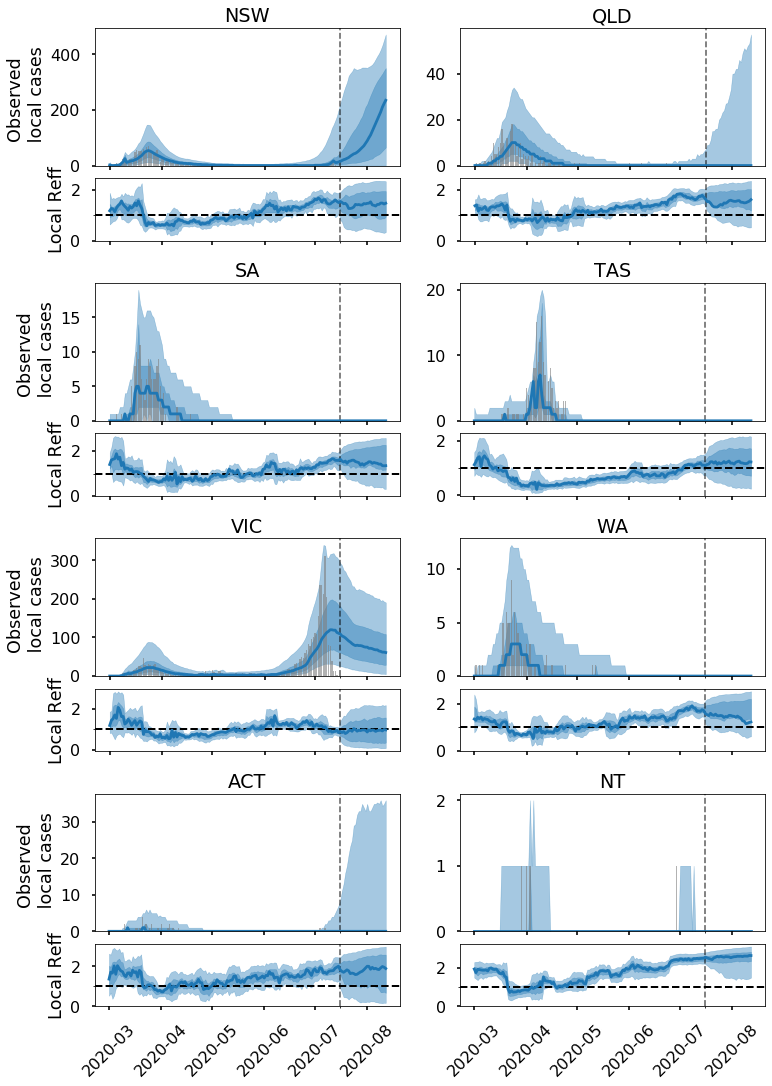

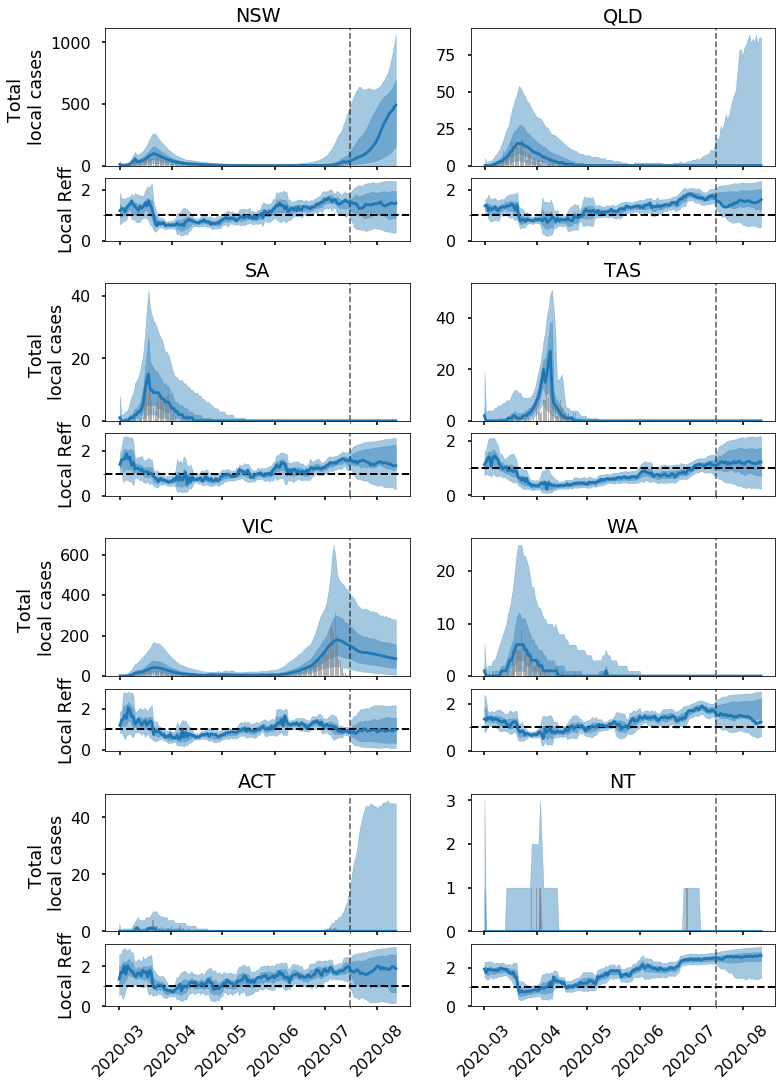

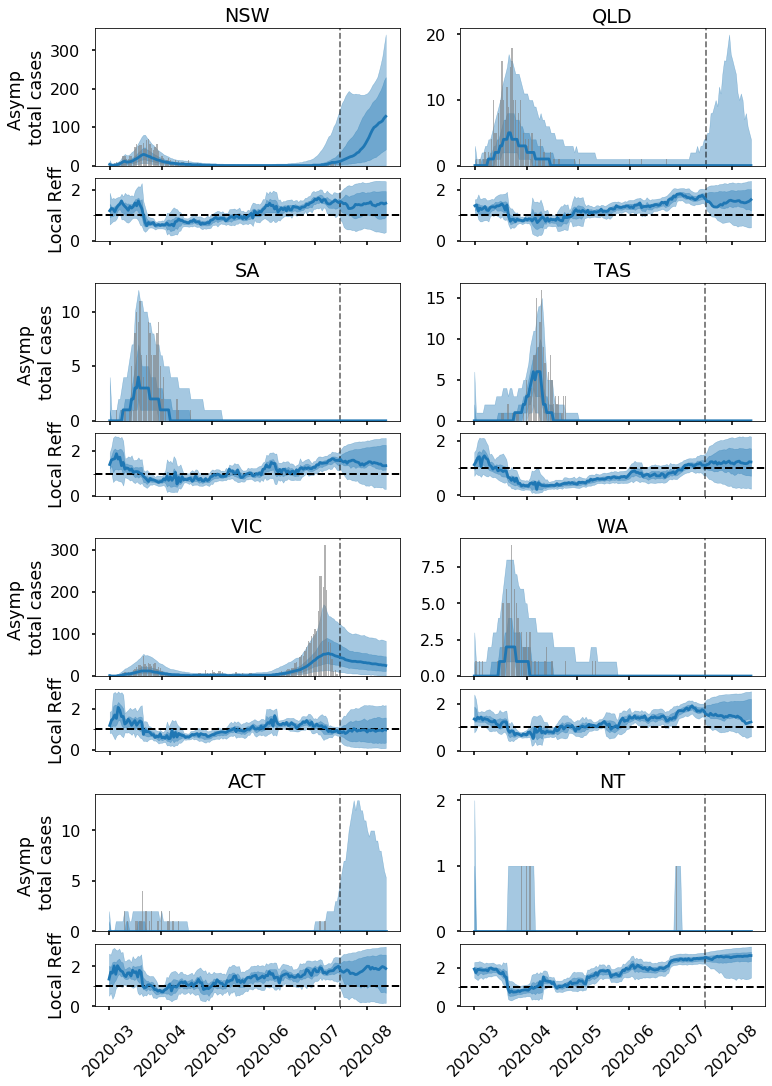

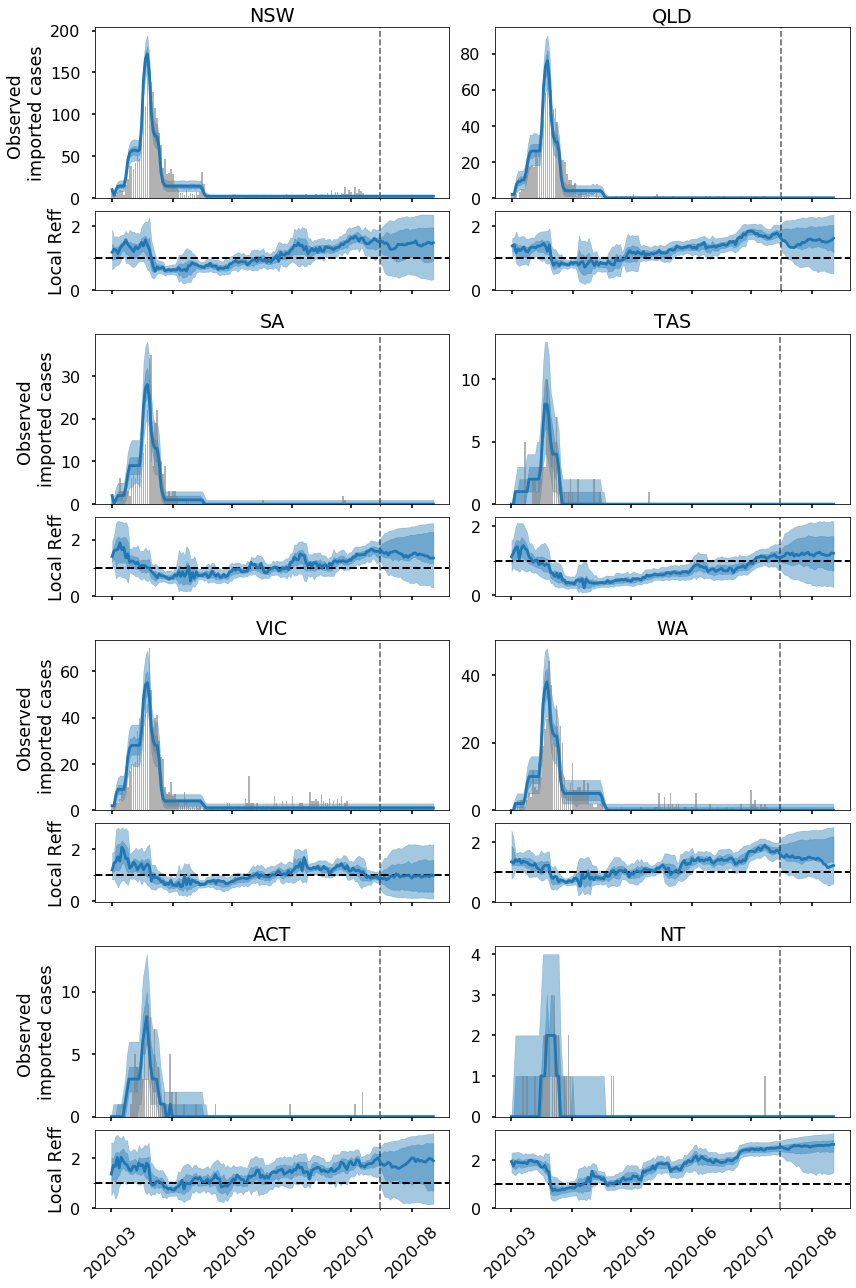

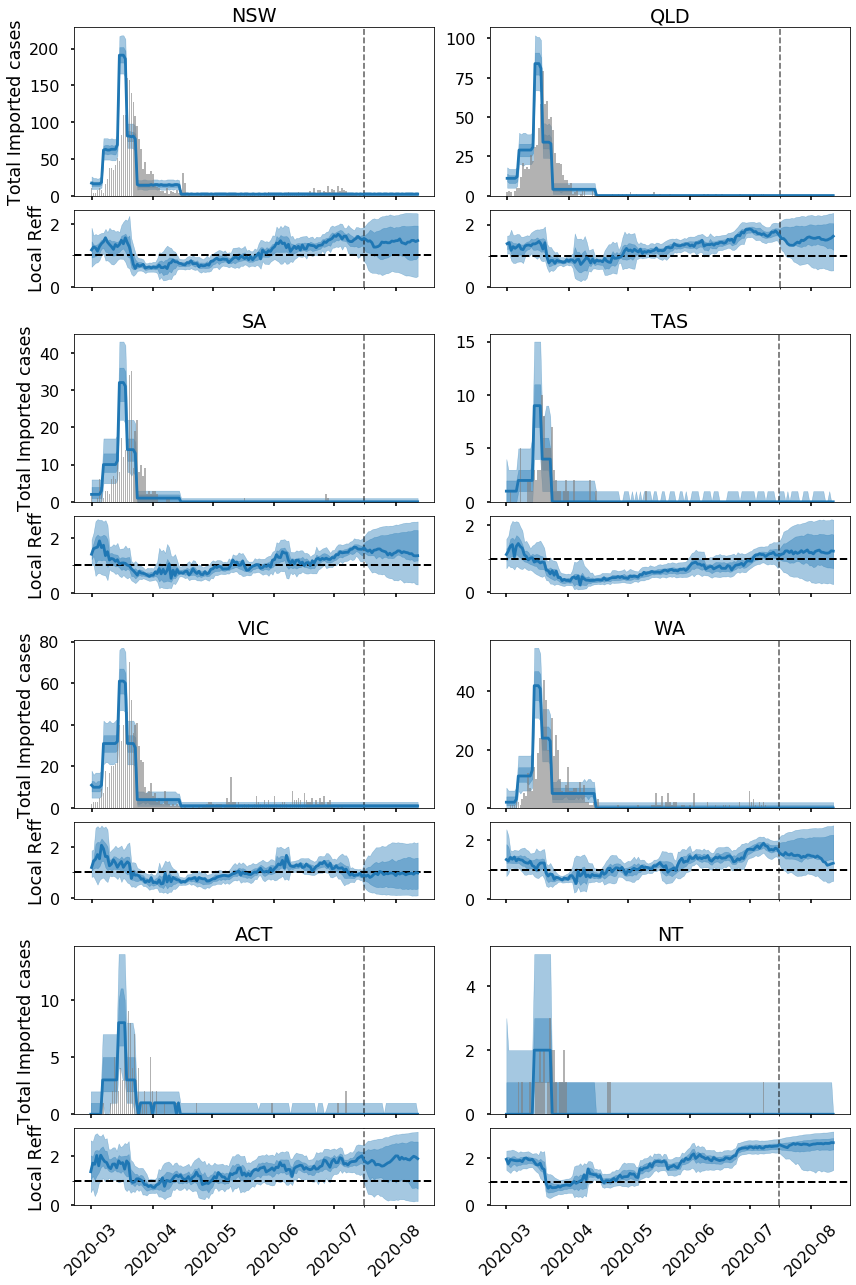

In [31]:
import pandas as pd
import matplotlib.gridspec as gridspec
from datetime import timedelta

plt.style.use("seaborn-poster")
states = ['NSW','QLD','SA','TAS','VIC','WA','ACT','NT']
n_sims = 3000
start_date = '2020-03-01'
days = 165




end_date = pd.to_datetime(start_date,format='%Y-%m-%d') + timedelta(days=days-1)

print("forecast up to: {}".format(end_date))

df_results = pd.read_parquet("../results/quantiles"+forecast_type+start_date+"sim_"+str(
    n_sims)+"days_"+str(days)+".parquet")

df_results = pd.melt(df_results, id_vars=['state','date','type'],
                     value_vars=['bottom','lower','median','upper','top'],
                    )

df_results = pd.pivot_table(df_results, 
                            index=['state','type','variable'],
                            columns='date',
                            values='value')


## Local cases
fig = plt.figure(figsize=(12,18))
gs = fig.add_gridspec(4,2)
for i,state in enumerate(states):
    gs0 = gridspec.GridSpecFromSubplotSpec(3, 1, subplot_spec=gs[i])
    ax = fig.add_subplot(gs0[:2,0])
    ax2 = fig.add_subplot(gs0[2,0], sharex=ax)
    
    dfplot = df_cases_state_time.loc[
        (df_cases_state_time.STATE==state) 
        & (df_cases_state_time.date_inferred >=start_date) 
        & (df_cases_state_time.date_inferred <=end_date)]
    
    ax.bar(dfplot.date_inferred,dfplot.local, label='Actual',color='grey', alpha=0.6)
    
    ax,ax2= plot_results(df_results.loc[state], ['total_inci_obs'],ax_arg = (ax,ax2),summary=True, Reff=Reff.loc[state])
    
    #ax.set_ylim(top=70)
    if i%2==0:
        ax.set_ylabel("Observed \n local cases")
        ax2.set_ylabel("Local Reff")
    ax.set_title(state)
    if i< len(states)-2:
        ax.set_xticklabels([])
        ax.set_xlabel('')
    #ax.set_ylim((0,60))
plt.savefig("../figs/"+forecast_type+start_date+"local_inci_"+str(n_sims)+"days_"+str(days)+'.pdf')

##TOtal cases
fig = plt.figure(figsize=(12,18))
gs = fig.add_gridspec(4,2)
for i,state in enumerate(states):
    gs0 = gridspec.GridSpecFromSubplotSpec(3, 1, subplot_spec=gs[i])
    ax = fig.add_subplot(gs0[:2,0])
    ax2 = fig.add_subplot(gs0[2,0], sharex=ax)
    
    dfplot = df_cases_state_time.loc[
        (df_cases_state_time.STATE==state) 
        & (df_cases_state_time.date_inferred >=start_date) 
        & (df_cases_state_time.date_inferred <=end_date)]
    
    ax.bar(dfplot.date_inferred,dfplot.local, label='Actual',color='grey', alpha=0.6)
    
    ax,ax2= plot_results(df_results.loc[state], ['total_inci'],ax_arg = (ax,ax2),summary=True, Reff=Reff.loc[state])
    
    #ax.set_ylim(top=70)
    if i%2==0:
        ax.set_ylabel("Total \nlocal cases")
        ax2.set_ylabel("Local Reff")
    ax.set_title(state)
    if i< len(states)-2:
        ax.set_xticklabels([])
        ax.set_xlabel('')
plt.savefig("../figs/"+forecast_type+start_date+"local_total_"+str(n_sims)+"days_"+str(days)+'.pdf')


##asymp cases
fig = plt.figure(figsize=(12,18))
gs = fig.add_gridspec(4,2)
for i,state in enumerate(states):
    gs0 = gridspec.GridSpecFromSubplotSpec(3, 1, subplot_spec=gs[i])
    ax = fig.add_subplot(gs0[:2,0])
    ax2 = fig.add_subplot(gs0[2,0], sharex=ax)
    
    dfplot = df_cases_state_time.loc[
        (df_cases_state_time.STATE==state) 
        & (df_cases_state_time.date_inferred >=start_date) 
        & (df_cases_state_time.date_inferred <=end_date)]
    
    ax.bar(dfplot.date_inferred,dfplot.local, label='Actual',color='grey', alpha=0.6)
    
    ax,ax2= plot_results(df_results.loc[state], ['asymp_inci'],ax_arg = (ax,ax2),summary=True, Reff=Reff.loc[state])
    
    #ax.set_ylim(top=70)
    if i%2==0:
        ax.set_ylabel("Asymp \ntotal cases")
        ax2.set_ylabel("Local Reff")
    ax.set_title(state)
    if i< len(states)-2:
        ax.set_xticklabels([])
        ax.set_xlabel('')
        
## Imported cases
fig = plt.figure(figsize=(12,18))
gs = fig.add_gridspec(4,2)
for i,state in enumerate(states):
    gs0 = gridspec.GridSpecFromSubplotSpec(3, 1, subplot_spec=gs[i])
    ax = fig.add_subplot(gs0[:2,0])
    ax2 = fig.add_subplot(gs0[2,0], sharex=ax)
    
    dfplot = df_cases_state_time.loc[
        (df_cases_state_time.STATE==state) 
        & (df_cases_state_time.date_inferred >=start_date) 
        & (df_cases_state_time.date_inferred <=end_date)]
    
    ax.bar(dfplot.date_inferred,dfplot.imported, label='Actual',color='grey', alpha=0.6)
    
    ax,ax2= plot_results(df_results.loc[state], ['imports_inci_obs'],ax_arg = (ax,ax2),summary=True, Reff=Reff.loc[state])
    
    #ax.set_ylim(top=70)
    if i%2==0:
        ax.set_ylabel("Observed \nimported cases")
        ax2.set_ylabel("Local Reff")
    ax.set_title(state)
    if i< len(states)-2:
        ax.set_xticklabels([])
        ax.set_xlabel('')
                
plt.tight_layout()
plt.savefig("../figs/"+forecast_type+start_date+"imported_inci_"+str(n_sims)+"days_"+str(days)+'.pdf')

## unobserved Imported cases
fig = plt.figure(figsize=(12,18))
gs = fig.add_gridspec(4,2)
for i,state in enumerate(states):
    gs0 = gridspec.GridSpecFromSubplotSpec(3, 1, subplot_spec=gs[i])
    ax = fig.add_subplot(gs0[:2,0])
    ax2 = fig.add_subplot(gs0[2,0], sharex=ax)
    
    dfplot = df_cases_state_time.loc[
        (df_cases_state_time.STATE==state) 
        & (df_cases_state_time.date_inferred >=start_date) 
        & (df_cases_state_time.date_inferred <=end_date)]
    
    ax.bar(dfplot.date_inferred,dfplot.imported, label='Actual',color='grey', alpha=0.6)
    
    ax,ax2= plot_results(df_results.loc[state], ['imports_inci'],ax_arg = (ax,ax2),summary=True, Reff=Reff.loc[state])
    
    #ax.set_ylim(top=70)
    if i%2==0:
        ax.set_ylabel("Total Imported cases")
        ax2.set_ylabel("Local Reff")
    ax.set_title(state)
    if i< len(states)-2:
        ax.set_xticklabels([])
        ax.set_xlabel('')
                
plt.tight_layout()
plt.show()

In [ ]:
#National level plot
import pandas as pd
df_national = pd.DataFrame()
for i,state in enumerate(states):
    date_col = [day.strftime('%Y-%m-%d') for day in pd.date_range(start_date,end_date)]
    if forecast_type is None:
        df_results = pd.read_parquet("../results/"+state+start_date+"sim_results"+str(n_sims)+"days_"+str(days)+'.parquet',columns=date_col)
    else:
        df_results = pd.read_parquet("../results/"+state+start_date+"sim_"+forecast_type+str(n_sims)+"days_"+str(days)+".parquet",columns=date_col)
    
        
    df_national = pd.concat([df_national,df_results])
    
df_results = df_national.reset_index().groupby(['Category','sim']).sum()
dfplot = df_cases_state_time.loc[
         (df_cases_state_time.date_inferred >=start_date) 
        & (df_cases_state_time.date_inferred <=end_date)].groupby('date_inferred').sum()

fig, ax= plot_results(df_results, ['symp_inci_obs'],plotpath=False,log=False)    
ax.bar(dfplot.index,dfplot.local, label='Actual',color='grey',alpha=0.6 )


ax.set_ylabel("Observed local cases per day")

plt.savefig("../figs/"+forecast_type+start_date+"national_inci_obs"+str(n_sims)+"days_"+str(days)+'.pdf')
plt.show()


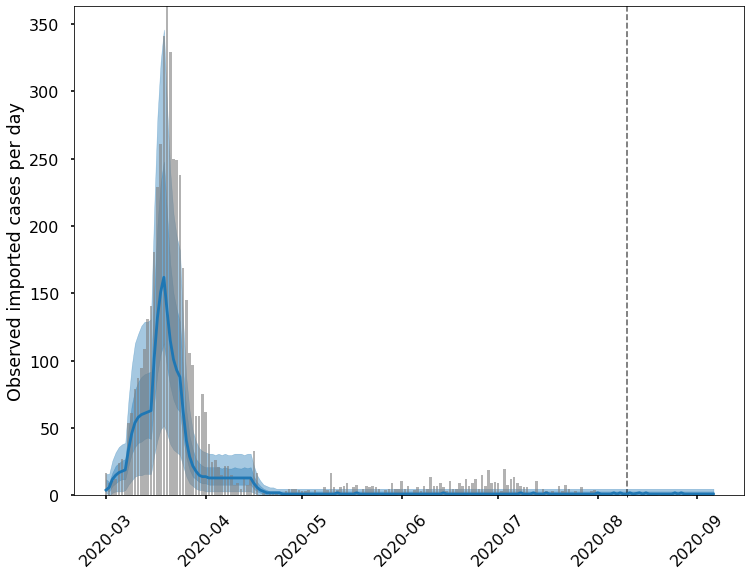

In [26]:
#National level imports
df_national = pd.DataFrame()
for i,state in enumerate(states):
    date_col = [day.strftime('%Y-%m-%d') for day in pd.date_range(start_date,end_date)]
    if forecast_type is None:
        df_results = pd.read_parquet("../results/"+state+start_date+"sim_results"+str(n_sims)+"days_"+str(days)+'.parquet',columns=date_col)
    else:
        df_results = pd.read_parquet("../results/"+state+start_date+"sim_"+forecast_type+str(n_sims)+"days_"+str(days)+".parquet",columns=date_col)
    
     
    df_national = pd.concat([df_national,df_results])
    
df_results = df_national.reset_index().groupby(['Category','sim']).sum()
dfplot = df_cases_state_time.loc[
         (df_cases_state_time.date_inferred >=start_date) 
        & (df_cases_state_time.date_inferred <=end_date)].groupby('date_inferred').sum()

fig, ax= plot_results(df_results, ['imports_inci_obs'],plotpath=False,log=False)    

ax.bar(dfplot.index,dfplot.imported, label='Actual',color='grey',alpha=0.6 )
#ax.set_ylim((0,300))
ax.set_ylabel("Observed imported cases per day")

plt.savefig("../figs/"+forecast_type+start_date+"national_imp_obs"+str(n_sims)+"days_"+str(days)+'.pdf')
plt.show()

/anaconda3/lib/python3.6/site-packages/fastparquet/core.py:279: UserWarning: Non-categorical multi-index is likely brittle
  warnings.warn("Non-categorical multi-index is likely brittle")


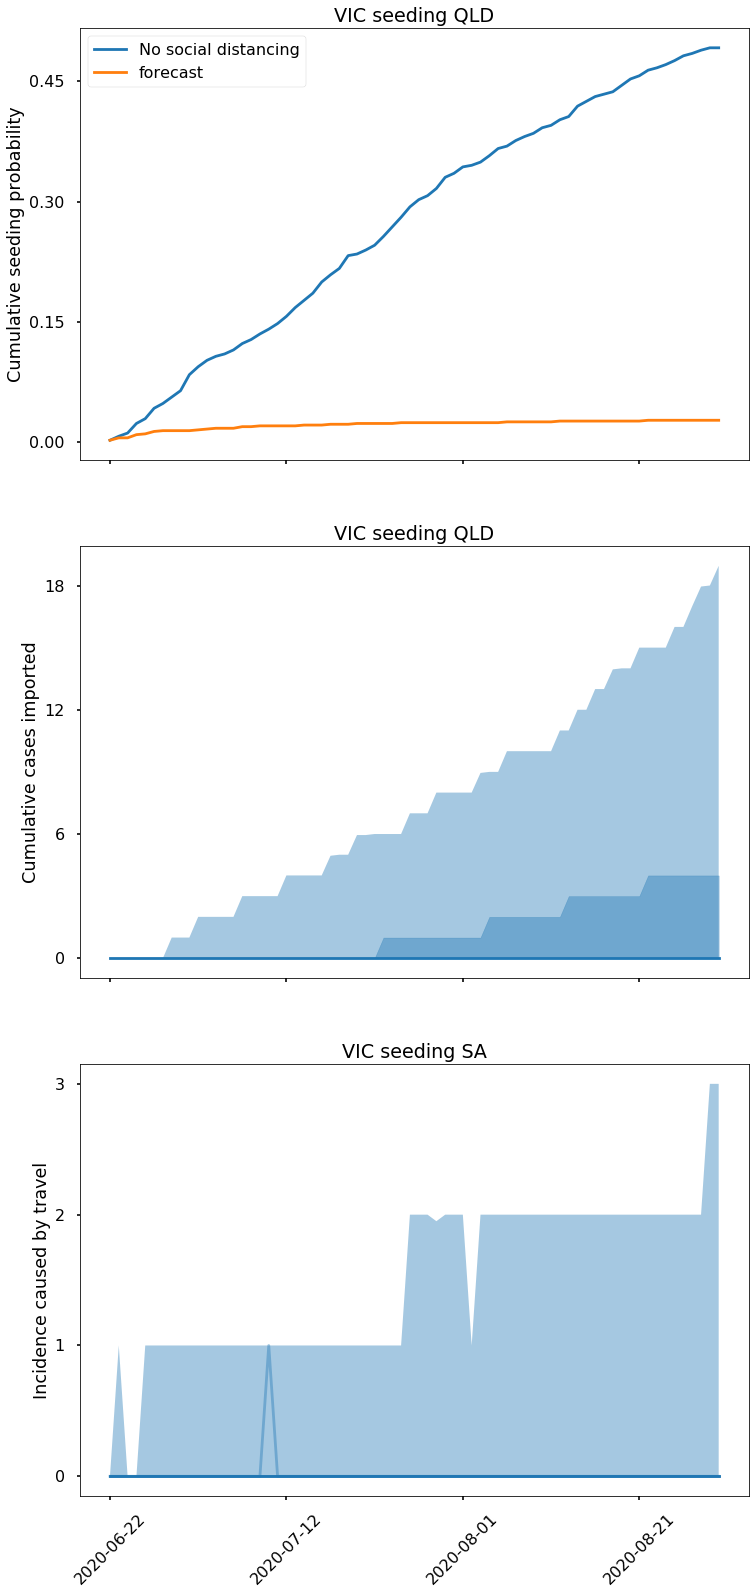

In [53]:
## analyse the cross border sims
state='VIC'
cross_border_state='QLD'
date_col = [day.strftime('%Y-%m-%d') for day in pd.date_range(start_date,end_date)]
date_col = [date for date in date_col if date >='2020-06-22']
df_results = pd.read_parquet("../results/"+state+start_date+"sim_"+forecast_type+str(n_sims)+"days_"+str(days)+".parquet",
                             columns=date_col )

seeds =df_results.loc['travel_seeds']
seeds = seeds.cumsum(axis=1)
seeded = seeds.applymap(lambda x: 1 if x>0 else 0)
fig,(ax,ax2,ax3) = plt.subplots(figsize=(12,27), nrows=3,sharex=True)

ax.plot(seeded.mean(),label='No social distancing')

ax.set_title(state+" seeding "+cross_border_state) #cross border state
ax.set_ylabel("Cumulative seeding probability")
#ax.tick_params('x',rotation=45)
ax.xaxis.set_major_locator(plt.MaxNLocator(4))
ax.yaxis.set_major_locator(plt.MaxNLocator(4))
#plt.savefig("../figs/open_border_cumuprob_VIC"+str(n_sims)+"days_"+str(days)+'.pdf')
#fig,ax = plt.subplots(figsize=(12,9))

ax2.plot(seeds.median())
ax2.fill_between(date_col, seeds.quantile(0.05), seeds.quantile(0.95),alpha=0.4)
ax2.fill_between(date_col, seeds.quantile(0.25), seeds.quantile(0.75),alpha=0.4,color='C0')
ax2.set_title(state+" seeding "+cross_border_state)  #cross border state
ax2.set_ylabel("Cumulative cases imported")
ax2.tick_params('x',rotation=45)
ax2.xaxis.set_major_locator(plt.MaxNLocator(4))
ax2.yaxis.set_major_locator(plt.MaxNLocator(4))
#plt.savefig("../figs/open_border_cumucases_VIC"+str(n_sims)+"days_"+str(days)+'.pdf')

cases = df_results.loc['travel_induced_cases'+cross_border_state] #cross_border_state
#cases = cases.cumsum(axis=1)

ax3.plot(cases.median())
ax3.plot(cases.loc[6],color='C0',alpha=0.4)
ax3.plot(cases.loc[69],color='C0',alpha=0.4)
ax3.fill_between(date_col, cases.quantile(0.05), cases.quantile(0.95),alpha=0.4)
ax3.fill_between(date_col, cases.quantile(0.25), cases.quantile(0.75),alpha=0.4,color='C0')
ax3.set_title(state+" seeding SA")  #cross border state
ax3.set_ylabel("Incidence caused by travel")
ax3.tick_params('x',rotation=45)
ax3.xaxis.set_major_locator(plt.MaxNLocator(4))
ax3.yaxis.set_major_locator(plt.MaxNLocator(4))

#Overplot R_L
if forecast_type=='R_L0':
    forecast_type='R_L'
    df_results1 = pd.read_parquet("../results/"+state+start_date+"sim_"+forecast_type+str(n_sims)+"days_"+str(days)+".parquet",
                             columns=date_col )
    
    seeds1 =df_results1.loc['travel_seeds']
    seeds1 = seeds1.cumsum(axis=1)
    seeded1 = seeds1.applymap(lambda x: 1 if x>0 else 0)
    ax.plot(seeded1.mean(),label='forecast')
    ax.legend()
    forecast_type='R_L0'
plt.savefig("../figs/open_border_inci_"+forecast_type+state+"to"+cross_border_state+str(n_sims)+"days_"+str(days)+'.pdf')
plt.show()

/anaconda3/lib/python3.6/site-packages/fastparquet/core.py:279: UserWarning: Non-categorical multi-index is likely brittle
  warnings.warn("Non-categorical multi-index is likely brittle")


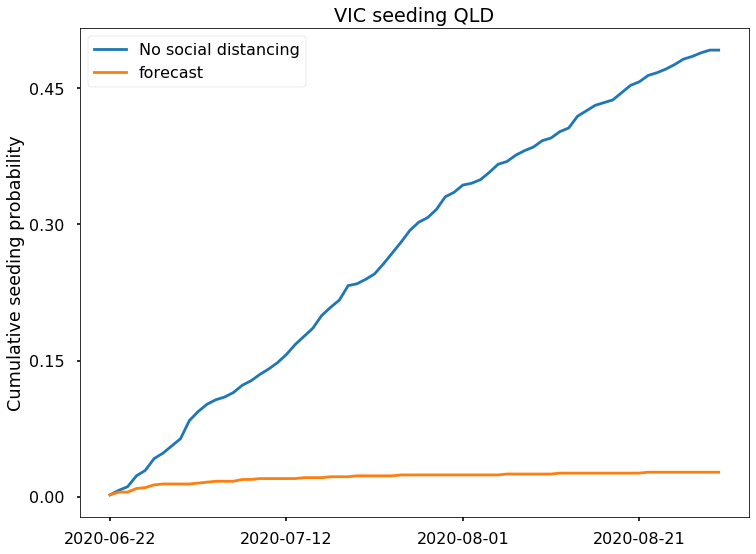

In [54]:
fig,ax = plt.subplots(figsize=(12,9),sharex=True)

ax.plot(seeded.mean(),label='No social distancing')
ax.set_title(state+" seeding "+cross_border_state) #cross border state
ax.set_ylabel("Cumulative seeding probability")
#ax.tick_params('x',rotation=45)
ax.xaxis.set_major_locator(plt.MaxNLocator(4))
ax.yaxis.set_major_locator(plt.MaxNLocator(4))
#Overplot R_L
if forecast_type=='R_L0':
    forecast_type='R_L'
    df_results1 = pd.read_parquet("../results/"+state+start_date+"sim_"+forecast_type+str(n_sims)+"days_"+str(days)+".parquet",
                             columns=date_col )
    
    seeds1 =df_results1.loc['travel_seeds']
    seeds1 = seeds1.cumsum(axis=1)
    seeded1 = seeds1.applymap(lambda x: 1 if x>0 else 0)
    ax.plot(seeded1.mean(),label='forecast')
    ax.legend()
    forecast_type='R_L0'
plt.savefig('../figs/open_border_seeding'+state+"to"+cross_border_state+".pdf")

forecast up to: 2020-08-30 00:00:00
NSW


/anaconda3/lib/python3.6/site-packages/fastparquet/core.py:279: UserWarning: Non-categorical multi-index is likely brittle
  warnings.warn("Non-categorical multi-index is likely brittle")


QLD
SA
TAS
VIC
WA
ACT
NT


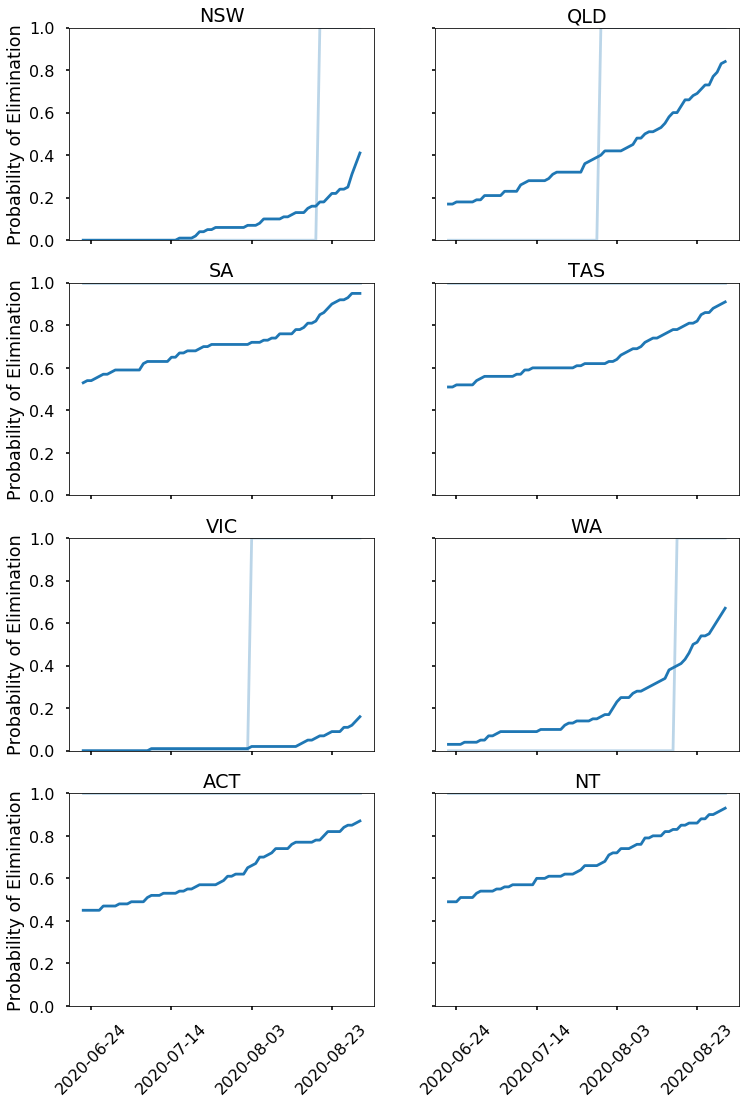

In [86]:
# Extinction probability

import matplotlib.pyplot as plt
import pandas as pd
import matplotlib.gridspec as gridspec
import numpy as np
from datetime import timedelta

plt.style.use("seaborn-poster")
states = ['NSW','QLD','SA','TAS','VIC','WA','ACT','NT']
n_sims = 100
start_date = '2020-03-01'
days = 183
forecast_type = 'R_L0' #default None

end_date = pd.to_datetime(start_date,format='%Y-%m-%d') + timedelta(days=days-1)

print("forecast up to: {}".format(end_date))
today_s = '2020-06-22'
today = pd.to_datetime(today_s).dayofyear - pd.to_datetime(start_date).dayofyear
weeks_interest = [ today + i for i in range(days-today)]  #six week forecast, day units from today
cases_afterd ={}

#dates of forecast
date_col = [day.strftime('%Y-%m-%d') for day in pd.date_range(pd.to_datetime(today_s),end_date)]

def is_extinct(cases,date,em):
    """
    Function to take in (row) of cases and determine if extinct yet. 1 if extinct,
    0 if cases remain
    """
    #using time as columns, rows as sims
    if len(cases.shape)==1:
  
        e = sum(cases[date:])
        if e> 0:
            return 0
        else:

            return 1
    else:
        print("argument was an array")
        e = sum(cases[date:,:],axis=1)
        return (e >0).astype(int)

fig, ax = plt.subplots(nrows=len(states)//2,ncols=2, figsize=(12,18),sharex=True,sharey=True)


for i,state in enumerate(states):
    df_results = pd.read_parquet("../results/"+state+start_date+"sim_"+forecast_type+str(n_sims)+"days_"+str(days)+".parquet",
                                )

    print(state)
    df_inci = df_results.loc['total_inci']

    df_inci = df_inci.loc[df_inci.bad_sim ==0] #only take good sims
    
    df_inci['extinct_end'] = (df_inci.cases_after==0).astype(int)
    df_inci.loc[df_inci.bad_sim==1,'extinct_end'] = pd.np.NaN
    #print(df_inci.extinct_end.value_counts())

    extinct_sims = df_inci.loc[df_inci.extinct_end==1,date_col]

    for week in weeks_interest:
        #weeks_interest has indices for getting the right columns from 'today' onwards
        if extinct_sims.shape[0]>0:
            #if there are some extinct_sims
            df_inci.loc[df_inci.extinct_end==1,str(week)] = extinct_sims.apply(is_extinct, args=(week-today,1),
                                                                               axis=1, raw=True).values
        #non-extinct sims
        df_inci.loc[df_inci.extinct_end==0, str(week)] = 0
    #perpetual_sims['not_extinct'] = df_results.loc['total_inci']

    cases_afterd[state] = df_inci[[str(wk)  for wk in weeks_interest]].mean()
    cases_afterd[state].index = [day for day in pd.date_range(pd.to_datetime(today_s),end_date)]
    
    
    row = i//2
    col = i%2
    ax[row,col].plot(cases_afterd[state],label='mean')
    batch_means = np.zeros(shape=(n_sims//100,len(weeks_interest)))
    for batch in range(n_sims//100):
        if n_sims<=1000:
            ax[row,col].plot(
                [day for day in pd.date_range(pd.to_datetime(today_s),end_date)],
                             df_inci.loc[batch:2*batch,[str(wk)  for wk in weeks_interest]].mean(axis=0), color='C0',alpha=0.3)
        else:
            batch_means[batch,:] = df_inci.loc[batch:2*batch,[str(wk)  for wk in weeks_interest]].mean(axis=0)

    
    if n_sims>1000:
        ax[row,col].fill_between(cases_afterd[state].index, 
                             np.quantile(batch_means,0.05,axis=0),
                            np.quantile(batch_means,0.95,axis=0),
                            alpha=0.4)
        
    ax[row,col].set_title(state)
    ax[row,col].tick_params('x',rotation=45)
    ax[row,col].xaxis.set_major_locator(plt.MaxNLocator(5))
    ax[row,col].yaxis.set_major_locator(plt.MaxNLocator(5))
    ax[row,col].set_ylim((0,1))
    if col==0:
        ax[row,col].set_ylabel("Probability of Elimination")
plt.savefig("../figs/"+forecast_type+start_date+"elimination_"+str(n_sims)+"days_"+str(days)+'.pdf')
plt.show()    

forecast up to: 2020-08-23 00:00:00
NSW
QLD
SA
TAS
WA


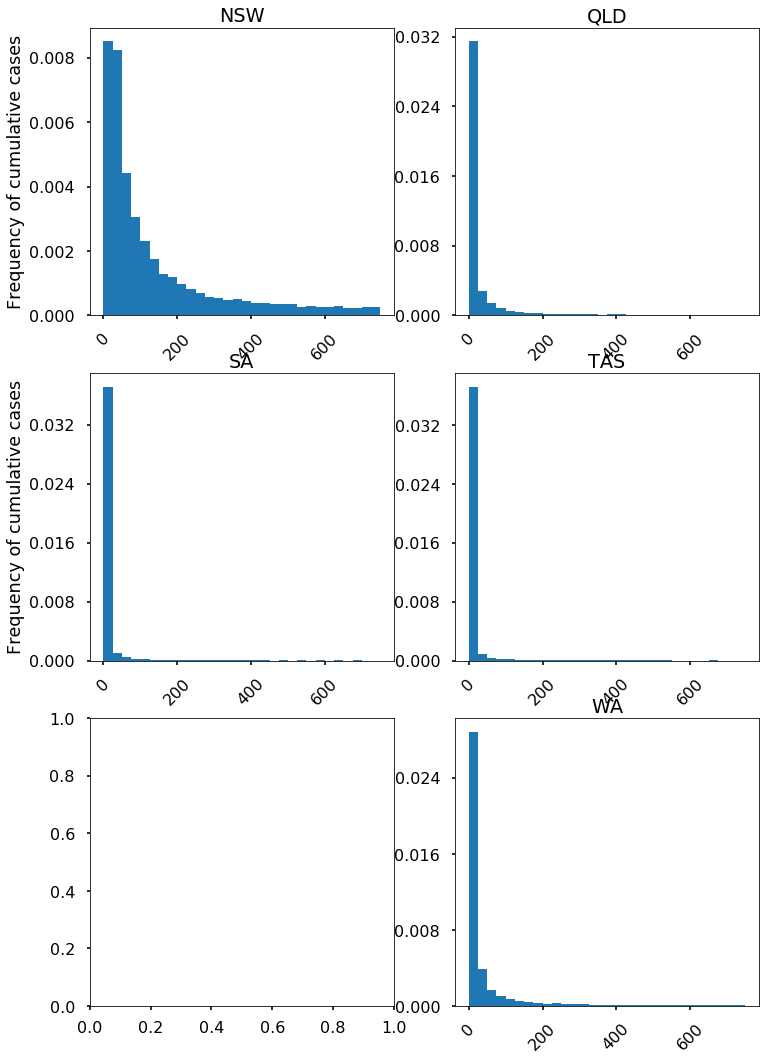

In [56]:
import matplotlib.pyplot as plt
import pandas as pd
import matplotlib.gridspec as gridspec
import numpy as np
from datetime import timedelta

plt.style.use("seaborn-poster")
states = ['NSW','QLD','SA','TAS','VIC','WA']#,'ACT','NT']
n_sims = 20000
start_date = '2020-03-01'
days = 176
forecast_type = 'R_L0' #default None

end_date = pd.to_datetime(start_date,format='%Y-%m-%d') + timedelta(days=days-1)

print("forecast up to: {}".format(end_date))
today_s = '2020-06-15'
today = pd.to_datetime(today_s).dayofyear - pd.to_datetime(start_date).dayofyear
weeks_interest = [ today + i for i in range(days-today)]  #six week forecast, day units from today
cases_afterd ={}

#dates of forecast
date_col = [day.strftime('%Y-%m-%d') for day in pd.date_range(pd.to_datetime(today_s),end_date)]

fig, ax = plt.subplots(nrows=len(states)//2,ncols=2, figsize=(12,18),sharex=False,sharey=False)

for i,state in enumerate(states):
    if forecast_type=='R_L0':
        if state=='VIC':
            if n_sims==20000:
                continue
    df_results = pd.read_parquet("../results/"+state+start_date+"sim_"+forecast_type+str(n_sims)+"days_"+str(days)+".parquet",
                                )

    print(state)
    
        
    row = i//2
    col = i%2
    
    df_cumulative = df_results.loc['symp',date_col[-1]] + df_results.loc['asymp',date_col[-1]]
    df_cumulative = df_cumulative - (df_results.loc['symp',date_col[0]] + df_results.loc['asymp',date_col[0]])
    ax[row,col].hist(df_cumulative.values, bins=750//25, range=(0,750), density=True)
    
    
    ax[row,col].set_title(state)
    ax[row,col].tick_params('x',rotation=45)
    ax[row,col].xaxis.set_major_locator(plt.MaxNLocator(5))
    ax[row,col].yaxis.set_major_locator(plt.MaxNLocator(5))

    if col==0:
        ax[row,col].set_ylabel("Frequency of cumulative cases")
        
plt.savefig("../figs/"+forecast_type+start_date+"cumu_cases"+str(n_sims)+"days_"+str(days)+'.pdf')
plt.show()

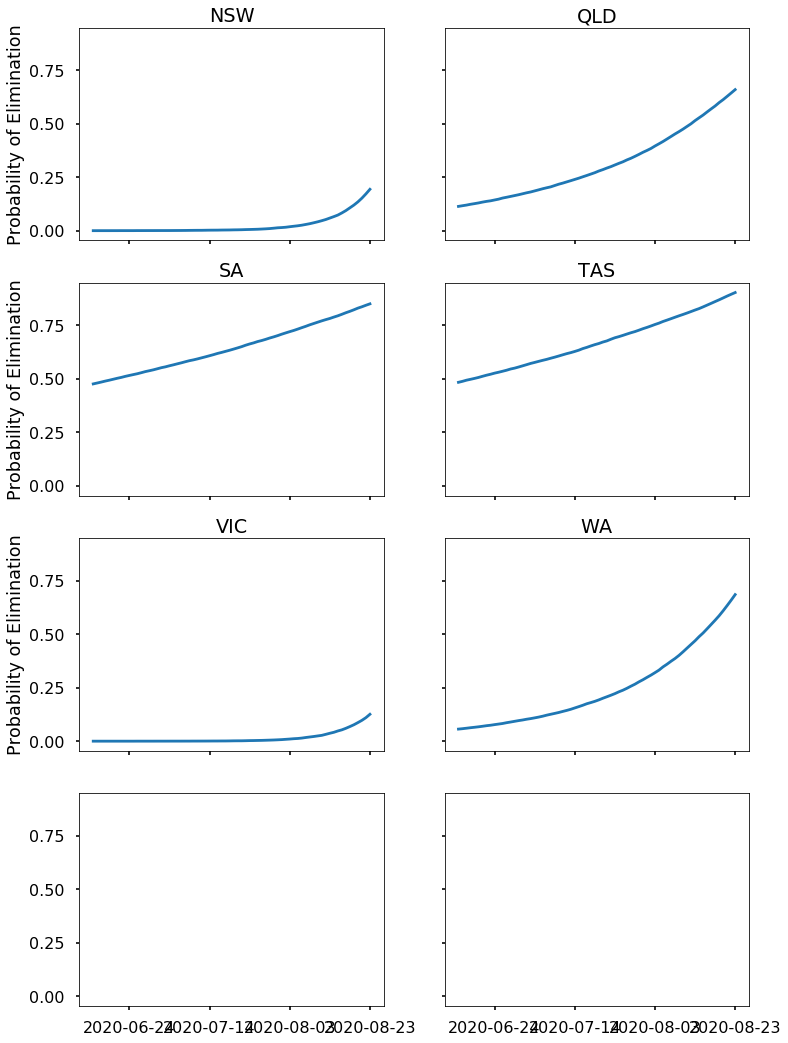

In [23]:
fig, ax = plt.subplots(nrows=4,ncols=2, figsize=(12,18),sharex=True,sharey=True)
for i,state in enumerate(states):
    row = i//2
    col = i%2
    ax[row,col].plot(cases_afterd[state])
    #ax[row,col].fill_between(cases_afterd[state].index, 
    #                         cases_afterd[state]-1.96*np.sqrt(cases_afterd[state]*(1-cases_afterd[state])/n_sims),
    #                        cases_afterd[state]+1.96*np.sqrt(cases_afterd[state]*(1-cases_afterd[state])/n_sims),
    #                        alpha=0.4)
    

    ax[row,col].set_title(state)
    ax[row,col].tick_params('x',rotation=45)
    ax[row,col].xaxis.set_major_locator(plt.MaxNLocator(4))
    ax[row,col].yaxis.set_major_locator(plt.MaxNLocator(4))
    
    if col==0:
        ax[row,col].set_ylabel("Probability of Elimination")
#ax[row,col].set_xlabel("Date")
#plt.savefig("../figs/"+forecast_type+start_date+"elimination_"+str(n_sims)+"days_"+str(days)+'.pdf')
plt.show()

In [4]:
##Read in all NNDSS data files on this local machine
import pandas as pd
from datetime import timedelta
import glob,os

nndss_files = glob.glob("../data/COVID-19 UoM *.xlsx")
nndss_files = sorted(nndss_files, key = os.path.getmtime)
missing_cases = pd.DataFrame()
totals = pd.DataFrame()
recent_missing = pd.DataFrame()
recent_totals = pd.DataFrame()
for file in nndss_files:
    df = pd.read_excel(file,
                       parse_dates=['SPECIMEN_DATE','NOTIFICATION_DATE','NOTIFICATION_RECEIVE_DATE','TRUE_ONSET_DATE'],
                       dtype= {'PLACE_OF_ACQUISITION':str})
    df.PLACE_OF_ACQUISITION.fillna('00038888',inplace=True) #Fill blanks with simply unknown

    df['date_inferred'] = df.TRUE_ONSET_DATE
    date = pd.to_datetime(file[21:-10])
    missing_cases[date] =df.groupby('STATE').TRUE_ONSET_DATE.agg(lambda x: sum(x.isna()))
    totals[date] = df.groupby('STATE').TRUE_ONSET_DATE.agg(len)
    
    recent_missing[date] = df.loc[df.NOTIFICATION_RECEIVE_DATE >= date +pd.Timedelta("-14 days")
                                 ].groupby('STATE').TRUE_ONSET_DATE.agg(lambda x: sum(x.isna()))
    
    recent_totals[date] = df.loc[df.NOTIFICATION_RECEIVE_DATE >= date +pd.Timedelta("-14 days")
                                 ].groupby('STATE').TRUE_ONSET_DATE.agg(len)

display(totals)
display(missing_cases)

display(recent_missing)
display(recent_totals)



,2020-06-29,2020-07-03,2020-07-06,2020-07-08,2020-07-09,2020-07-13,2020-07-17,2020-07-28,2020-07-31,2020-08-04,2020-08-05,2020-08-10
STATE,,,,,,,,,,,,
ACT,108,108,108,108,111,113,113,113,113,113,113,113
NSW,3368,3400,3428,3435,3450,3487,3539,3693,3748,3796,3817,3877
NT,29,30,30,30,30,31,31,31,31,31,33,33
QLD,1067,1067,1067,1068,1068,1071,1071,1075,1081,1084,1085,1084
SA,436,439,439,439,439,439,440,441,442,442,442,454
TAS,228,228,228,228,228,228,228,229,229,229,229,229
VIC,2107,2361,2661,2947,3111,3995,5137,8992,10515,12390,13068,15015
WA,593,596,596,605,607,612,624,632,636,636,637,638


,2020-06-29,2020-07-03,2020-07-06,2020-07-08,2020-07-09,2020-07-13,2020-07-17,2020-07-28,2020-07-31,2020-08-04,2020-08-05,2020-08-10
STATE,,,,,,,,,,,,
ACT,0,0,0,0,0,0,0,0,0,0,0,0
NSW,0,0,0,0,0,0,0,0,0,0,0,0
NT,0,0,0,0,0,0,0,0,0,0,0,0
QLD,0,0,0,0,0,0,0,0,0,0,0,0
SA,5,0,0,0,0,0,1,2,3,11,11,19
TAS,9,9,9,9,9,9,9,9,9,9,9,9
VIC,210,198,291,417,490,858,1301,2353,2861,3066,3501,3719
WA,39,0,0,9,11,8,14,4,8,8,8,9


,2020-06-29,2020-07-03,2020-07-06,2020-07-08,2020-07-09,2020-07-13,2020-07-17,2020-07-28,2020-07-31,2020-08-04,2020-08-05,2020-08-10
STATE,,,,,,,,,,,,
NSW,0,0,0,0,0,0,0,0,0,0,0,0
QLD,0,0,0,0,0,0,0,0,0,0,0,0
VIC,136,111,208,331,397,751,1096,1788,2203,1763,2494,2193
WA,2,0,0,9,11,8,14,4,4,4,4,5


,2020-06-29,2020-07-03,2020-07-06,2020-07-08,2020-07-09,2020-07-13,2020-07-17,2020-07-28,2020-07-31,2020-08-04,2020-08-05,2020-08-10
STATE,,,,,,,,,,,,
NSW,51,72,90,90,99,104,132,160,173,145,141,124
QLD,2,2,2,2,2,4,4,4,10,12,12,9
VIC,371,528,811,1062,1191,1890,2576,4310,5397,4598,6262,6138
WA,4,6,5,12,14,19,28,16,8,6,7,7


/anaconda3/lib/python3.6/site-packages/pandas/plotting/_matplotlib/converter.py:103: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


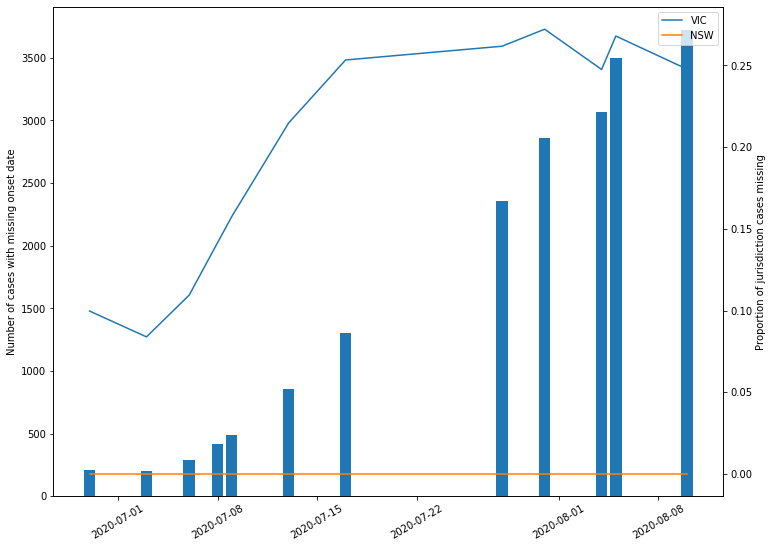

In [5]:
fig, ax = plt.subplots(figsize=(12,9))
ax2 = ax.twinx()
import seaborn
ax.bar(missing_cases.columns, missing_cases.loc['VIC'])

ax2.plot(missing_cases.columns, missing_cases.loc['VIC']/totals.loc['VIC'],
         label='VIC')

ax2.plot(missing_cases.columns, missing_cases.loc['NSW']/totals.loc['NSW'],
         label='NSW')

ax.set_ylabel("Number of cases with missing onset date")
ax2.set_ylabel("Proportion of jurisdiction cases missing")

ax.tick_params('x',rotation = 30)
plt.legend()
plt.show()


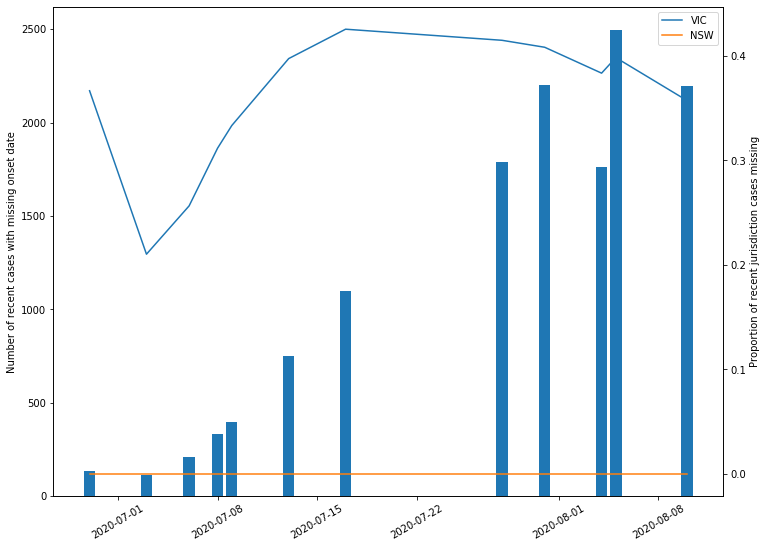

In [6]:
fig, ax = plt.subplots(figsize=(12,9))
ax2 = ax.twinx()
import seaborn
ax.bar(recent_missing.columns, recent_missing.loc['VIC'])

ax2.plot(recent_missing.columns, recent_missing.loc['VIC']/recent_totals.loc['VIC'],
         label='VIC')

ax2.plot(missing_cases.columns, recent_missing.loc['NSW']/recent_totals.loc['NSW'],
         label='NSW')

ax.set_ylabel("Number of recent cases with missing onset date")
ax2.set_ylabel("Proportion of recent jurisdiction cases missing")

ax.tick_params('x',rotation = 30)
plt.legend()
plt.show()

## Forecast of cases

Here we use the simulations to estimate the probability of that there will be ore than 10 cases over the next 2 weeks.

In [41]:
##

today = pd.to_datetime('2020-06-15').dayofyear - pd.to_datetime(start_date).dayofyear
num_days = 14
all_cases_at_end ={}
for i,state in enumerate(states):
    if forecast_type is None:
        df_results = pd.read_parquet("../results/"+state+start_date+"sim_results"+str(n_sims)+"days_"+str(days)+'.parquet')
    else:
        df_results = pd.read_parquet("../results/"+state+start_date+"sim_"+forecast_type+str(n_sims)+"days_"+str(days)+".parquet")

#generate end probabilities
    cases_at_end = df_results.loc['symp_inci_obs',df_results.columns.values[today:today+14]].sum(axis=1)

    all_cases_at_end[state] = (cases_at_end>10).mean()
    
all_cases_at_end

/anaconda3/lib/python3.6/site-packages/fastparquet/core.py:279: UserWarning: Non-categorical multi-index is likely brittle
  warnings.warn("Non-categorical multi-index is likely brittle")


{'NSW': 0.242,
 'QLD': 0.0555,
 'SA': 0.026,
 'TAS': 0.004,
 'VIC': 0.7985,
 'WA': 0.0555,
 'ACT': 0.0475,
 'NT': 0.064}

## Record sims for Melb

In [7]:


import pandas as pd
import matplotlib.gridspec as gridspec
from datetime import timedelta, datetime

plt.style.use("seaborn-poster")
states = ['NSW','QLD','SA','TAS','VIC','WA','ACT','NT']
n_sims = 6001
start_date = '2020-03-01'
days = 204
forecast_type = 'R_L' #default None

end_date = pd.to_datetime(start_date,format='%Y-%m-%d') + timedelta(days=days-1)
sims_dict={
    'state': [],
    'date':[],
}
for n in range(n_sims):
    if n <2000:
        sims_dict['sim_'+str(n)] = []

print("forecast up to: {}".format(end_date))
date_col = [day.strftime('%Y-%m-%d') for day in pd.date_range(start_date,end_date)]

for i,state in enumerate(states):
    
    df_results = pd.read_parquet("../results/"+state+start_date+"sim_"+forecast_type+str(n_sims)+"days_"+str(days)+".parquet",columns=date_col)
    
    df_local = df_results.loc['total_inci_obs']

    sims_dict['date'].extend(date_col)
    sims_dict['state'].extend([state]*len(date_col))
    n=0
    print(state)
    for index, row in df_local.iterrows():
        if n==2000:
            break
        #if index>=2000:
        #    continue
        #else:
        if np.all(row.isna()):
            continue
        else:
            sims_dict['sim_'+str(n)].extend(row.values)
            n +=1
    print(n)
    while n < 2000:
        print("Resampling")
        for index, row in df_local.iterrows():
            if n==2000:
                break
            if np.all(row.isna()):
                continue
            else:
                sims_dict['sim_'+str(n)].extend(row.values)
                n +=1


df = pd.DataFrame.from_dict(sims_dict)
today =datetime.strftime(datetime.today(),format='%Y-%m-%d')
key ='local_obs'
df[df.select_dtypes(float).columns] = df.select_dtypes(float).astype(int)
df.to_csv('./UoA_'+today+str(key)+'.csv')

forecast up to: 2020-09-13 00:00:00
NSW
1238
Resampling
QLD
2000
SA
2000
TAS
2000
VIC
2000
WA
2000
ACT
2000
NT
2000


In [20]:
display(df.loc[df.state=='SA',['sim_'+str(3*i) for i in range(50) ]].tail(20))
sum(sum(df.isna().values))


,sim_0,sim_3,sim_6,sim_9,sim_12,sim_15,sim_18,sim_21,sim_24,sim_27,...,sim_120,sim_123,sim_126,sim_129,sim_132,sim_135,sim_138,sim_141,sim_144,sim_147
532,0,0,0,0,0,0,0,0,0,0,...,0,0,53,0,0,0,0,0,0,0
533,0,0,0,0,0,0,0,0,0,0,...,0,0,52,0,0,0,0,0,0,0
534,0,0,0,0,0,0,0,0,0,0,...,0,0,50,0,0,0,0,0,0,0
535,0,0,0,0,0,0,0,0,0,0,...,0,0,51,0,0,0,0,0,0,0
536,0,0,0,0,0,0,0,0,0,0,...,0,0,51,0,0,0,0,0,0,0
537,0,0,0,0,0,0,0,0,0,0,...,0,0,51,0,0,0,0,0,0,0
538,0,0,0,0,0,0,0,0,0,0,...,0,0,50,0,0,0,0,0,0,0
539,0,0,0,0,0,0,0,0,0,0,...,0,0,50,0,0,0,0,0,0,0
540,0,0,0,0,0,0,0,0,0,0,...,0,0,51,0,0,0,0,0,0,0
541,0,0,0,0,0,0,0,0,0,0,...,0,0,51,0,0,0,0,0,0,0


0

In [34]:
from datetime import datetime
##record quantiles for MElb

today =datetime.strftime(datetime.today(),format='%Y-%m-%d')
summary ={
    'total':{
        'state':[],
        'date':[],
        '0.01':[],
        '0.05':[],
        '0.25':[],
        '0.5':[],
        '0.75':[],
        '0.95':[],
        '0.99':[],
    },
    'total_obs':{
        'state':[],
        'date':[],
        '0.01':[],
        '0.05':[],
        '0.25':[],
        '0.5':[],
        '0.75':[],
        '0.95':[],
        '0.99':[],
    },
    'local':{
        'state':[],
        'date':[],
        '0.01':[],
        '0.05':[],
        '0.25':[],
        '0.5':[],
        '0.75':[],
        '0.95':[],
        '0.99':[],
    },
    'local_obs':{
        'state':[],
        'date':[],
        '0.01':[],
        '0.05':[],
        '0.25':[],
        '0.5':[],
        '0.75':[],
        '0.95':[],
        '0.99':[],
    },
}

        
for key in summary.keys():
    df_summary = pd.DataFrame()
    ####record simulations in csv
    for i,state in enumerate(states):
        if forecast_type is None:
            df_results = pd.read_hdf("../results/"+state+start_date+"sim_results"+str(n_sims)+"days_"+str(days)+'.h5', key='sims')
        else:
            df_results = pd.read_hdf("../results/"+state+start_date+"sim_"+forecast_type+str(n_sims)+"days_"+str(days)+".h5",key='sims')

        # Make total row
        for n in range(df_results.loc['symp_obs'].shape[0]):
            if key[:5] =='local':
                int_vars=['symp_inci','asymp_inci']
            if key[:5] =='total':
                int_vars=['symp_inci','asymp_inci','imports_inci']
            if key[-4:]=='_obs':
                int_vars = [var+'_obs' for var in int_vars]
            if len(int_vars)==3:
                df_results.loc[(key,n),:] = df_results.loc[(int_vars[0],n)] + df_results.loc[(int_vars[1],n)]+ df_results.loc[(int_vars[2],n)]
            else:
                df_results.loc[(key,n),:] = df_results.loc[(int_vars[0],n)] + df_results.loc[(int_vars[1],n)]
            
        summary[key]['state'].extend([state] * len(df_results.columns))
        #summary[key]['forecast_date'].extend([] * len(df_results.columns))
        summary[key]['date'].extend(df_results.columns.values)
        for quantile in [0.01,0.05,0.25,0.5,0.75,0.95,0.99]:
            summary[key][str(quantile)].extend(df_results.loc[key].quantile(quantile).astype(int).values)
    
    df_summary = pd.DataFrame.from_dict(summary[key])

    df_summary.to_csv('./UoA_'+today+str(key)+'.csv')

    

In [65]:
#find initial values for each state
df_cases_state_time.loc[(df_cases_state_time.date_inferred>='2020-03-01')].sort_values('date_inferred').head(30)

,STATE,date_inferred,imported,local,cum_imported,cum_local
341,VIC,2020-03-01,2,0,20,1
185,QLD,2020-03-01,2,0,16,3
250,SA,2020-03-01,2,0,8,0
55,NSW,2020-03-01,10,2,40,22
342,VIC,2020-03-02,3,0,23,1
56,NSW,2020-03-02,3,5,43,27
186,QLD,2020-03-02,3,1,19,4
441,WA,2020-03-03,1,1,4,1
187,QLD,2020-03-03,2,0,21,4
288,TAS,2020-03-03,1,0,3,0


In [7]:
##find alphas and betas for imports
days = 204
def period_dates(date):
    from datetime import timedelta
    #subtract 4 from date to infer period of entry when infected
    date = date-timedelta(days=4)
    if date <= pd.to_datetime('2020-03-01',format='%Y-%m-%d'):
        return 0
    elif date <= pd.to_datetime('2020-03-06',format='%Y-%m-%d'):
        return 1
    elif date <= pd.to_datetime('2020-03-13',format='%Y-%m-%d'):
        return 2
    elif date <= pd.to_datetime('2020-03-18',format='%Y-%m-%d'):
        return 3
    elif date <= pd.to_datetime('2020-03-23',format='%Y-%m-%d'):
        return 4
    elif date <= pd.to_datetime('2020-04-14',format='%Y-%m-%d'):
        return 5
    else:
        return 6
    
    
df_cases_state_time['period'] = df_cases_state_time.date_inferred.apply(
    period_dates
)
prior = [1,1/5]
num_days = [6,7,5,5,22,days-6-7-5-5-22]
alphas = df_cases_state_time.groupby(['STATE','period']).imported.sum() + prior[0]

betas = prior[1]+np.array(num_days)
print(betas)
alphas

[  6.2   7.2   5.2   5.2  22.2 159.2]


STATE  period
ACT    1           2
       2          22
       3          31
       4          17
       5          15
       6           3
NSW    0          66
       1          90
       2         408
       3         694
       4         380
       5         313
       6         297
NT     1           3
       2           4
       3           7
       4           9
       5           6
       6           4
QLD    0          25
       1          61
       2         190
       3         305
       4         162
       5          87
       6          27
SA     0          16
       1          14
       2          68
       3         115
       4          67
       5          26
       6          10
TAS    0           4
       1           6
       2          14
       3          33
       4          20
       5           9
       6           2
VIC    0          34
       1          58
       2         202
       3         222
       4         146
       5          84
       6         182

In [27]:
df_cases_state_time.loc[df_cases_state_time.STATE=='VIC'].tail(20)

,STATE,date_inferred,imported,local,cum_imported,cum_local
442,VIC,2020-05-31,1,4,852,762
443,VIC,2020-06-01,6,1,858,763
444,VIC,2020-06-02,2,0,860,763
445,VIC,2020-06-03,0,3,860,766
446,VIC,2020-06-04,2,3,862,769
447,VIC,2020-06-05,1,1,863,770
448,VIC,2020-06-06,3,3,866,773
449,VIC,2020-06-07,0,5,866,778
450,VIC,2020-06-09,2,2,868,780
451,VIC,2020-06-10,3,4,871,784
